# Прогнозирование следующего заказа пользователя

В данном проекте необходимо решить задачу предсказания следующего заказа пользователя в сервисе доставки (безотносительно конкретного момента времени, когда этот заказ произойдет). Заказ пользователя состоит из списка уникальных категорий товаров, вне зависимости от того, сколько продуктов каждой категории он взял.

Для решения данной задачи выполним следующие этапы:

1. Предобработка данных

   1.1. Импорт библиотек
   
   1.2. Загрузка данных
   
   1.3. Предварительный анализ данных
   
   1.4. Обработка данных
   
   1.5. Разделение на выборки
   
2. Исследовательский анализ данных
3. Обучение моделей

   3.1. Light GBM
   
   3.2. Cat Boost
   
   3.3. Random Forest
   
   3.4. Logistic Regression
   
4. Тестирование модели
5. Формирование предсказаний
6. Вывод


### Предобработка данных

#### Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import time
import phik

In [2]:
RANDOM_STATE = 12345

#### Загрузка данных

In [3]:
train = pd.read_csv('train.csv', parse_dates = ['order_completed_at'])
sub = pd.read_csv('sample_submission.csv')

In [4]:
train_original = train.copy()

#### Предварительный анализ данных

In [5]:
df_list = [train, sub]
df_names = ['train', 'sub']

In [6]:
for i, df in enumerate(df_list):
    print(df_names[i])
    print()    
    print('Размер датафрейма:')
    display(df.shape)
    display(df.info())
    display(df.head())
    print('Количество пропусков:')
    print(df.isna().sum())
    print('Количество дубликатов:', df.duplicated().sum())
    print()

train

Размер датафрейма:


(3123064, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123064 entries, 0 to 3123063
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   user_id             int64         
 1   order_completed_at  datetime64[ns]
 2   cart                int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 71.5 MB


None

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157


Количество пропусков:
user_id               0
order_completed_at    0
cart                  0
dtype: int64
Количество дубликатов: 0

sub

Размер датафрейма:


(790449, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790449 entries, 0 to 790448
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      790449 non-null  object
 1   target  790449 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 12.1+ MB


None

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0


Количество пропусков:
id        0
target    0
dtype: int64
Количество дубликатов: 0



Добавим столбец с целевым признаком и дополнительные признаки: ordered(количество покупок пользователя по каждой категории), orders_total(общее количество покупок пользователя), rating(доля каждой категории в заказах клиента).

In [7]:
%%time

train_raw = pd.get_dummies(train, columns = ['cart'], prefix='', prefix_sep='', dtype='bool')
train_raw = train_raw.groupby(['user_id', 'order_completed_at']).any().reset_index()

# Создаем столбец 'order_number', содержащий порядковый номер заказа для каждого пользователя
train_raw['order_number'] = train_raw.groupby(['user_id']).cumcount() 
train_raw = train_raw.drop('order_completed_at', axis=1)

# Разделение наборов данных по последнему заказу
last_order = train_raw.groupby(['user_id'])['order_number'].transform(max) == train_raw['order_number']
train = train_raw[~last_order].groupby('user_id').sum().reset_index()
valid = train_raw[last_order].reset_index(drop=True)

# Подсчет числа покупок для каждой категории для каждого пользователя
train_melt = pd.melt(train, id_vars=['user_id'], var_name='category', value_name='ordered')
valid_melt = pd.melt(valid, id_vars=['user_id'], var_name='category', value_name='target')

df = train_melt.copy()

# Общее количество покупок для каждого пользователя
order_number = valid[['user_id', 'order_number']].set_index('user_id').squeeze()
df['orders_total']= df['user_id'].map(order_number)

# Доля каждой категории в заказах клиента
df['rating'] = df['ordered'] / df['orders_total']

df['id'] = df['user_id'].astype(str) + ';' + df['category']

df['target'] = valid_melt['target'].astype(int)

# Удаление данных с id, которых нет в submission
df = df[df.id.isin(sub.id.unique())].reset_index(drop=True)

print((df.sort_values('id')['id'].values == df.sort_values('id')['id'].values).all())

# Общее количество покупок пользователя
total_ordered = df.groupby('category')['ordered'].sum()
df['total_ordered'] = df['category'].map(total_ordered)

df.head()

True
CPU times: total: 1min 5s
Wall time: 1min 7s


,user_id,category,ordered,orders_total,rating,id,target,total_ordered
0,7,0,0,10,0.000000,7;0,1,12922
1,8,0,1,7,0.142857,8;0,0,12922
2,9,0,1,45,0.022222,9;0,0,12922
3,12,0,1,20,0.050000,12;0,1,12922
4,13,0,3,16,0.187500,13;0,0,12922


In [8]:
df.describe()

,user_id,ordered,orders_total,rating,target,total_ordered
count,790449.000000,790449.000000,790449.000000,790449.000000,790449.000000,790449.000000
mean,8772.236142,2.794790,16.392377,0.240382,0.235965,17688.961333
std,5695.199690,4.182902,17.236483,0.225124,0.424600,17161.220472
min,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,3840.000000,1.000000,5.000000,0.071429,0.000000,4992.000000
50%,8110.000000,1.000000,11.000000,0.166667,0.000000,12505.000000
75%,13478.000000,3.000000,21.000000,0.333333,0.000000,23073.000000
max,19998.000000,136.000000,186.000000,1.000000,1.000000,77000.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790449 entries, 0 to 790448
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        790449 non-null  int64  
 1   category       790449 non-null  object 
 2   ordered        790449 non-null  int64  
 3   orders_total   790449 non-null  int64  
 4   rating         790449 non-null  float64
 5   id             790449 non-null  object 
 6   target         790449 non-null  int32  
 7   total_ordered  790449 non-null  int64  
dtypes: float64(1), int32(1), int64(4), object(2)
memory usage: 45.2+ MB


Изменим тип данных признака category и удалим столбец id.

In [10]:
df['category'] = df['category'].astype('int64')

In [11]:
df = df.drop(['id'], axis=1)

#### Разделение на выборки

In [12]:
y = df['target'] #извлечем целевой признак
X = df.drop(['target'], axis=1) #извлечем признаки

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, 
                                                    test_size = 0.2, 
                                                    random_state=RANDOM_STATE)

In [14]:
X_train.head(2)

,user_id,category,ordered,orders_total,rating,total_ordered
0,7,0,0,10,0.000000,12922
1,8,0,1,7,0.142857,12922


In [15]:
print('Строк в тренировочной выборке:', X_train.shape[0],
    'строк в тестовой выборке:', X_test.shape[0])

Строк в тренировочной выборке: 632359 строк в тестовой выборке: 158090


#### Стандартизация численных признаков

In [16]:
#произведем масштабирование данных для линейной регрессии
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()

scaler = StandardScaler()
scaler.fit(X_train)
X_train_lr = scaler.transform(X_train)
X_test_lr = scaler.transform(X_test)

<b>ВЫВОД.</b> 
Датасеты размерами (3123064, 3), (790449, 2) были исследованы, данные подготовлены для дальнейшего обучения:рассчитаны целевой и дополнительные признаки, удалены неинформативные столбцы. Размер преобразованного датафрейма для обучения: (790449, 8).
Произведено разделение на выборки, произведено масштабирование численных признаков.

### Исследовательский анализ данных

Проверим баланс классов целевого признака.

target
0    0.764035
1    0.235965
Name: proportion, dtype: float64

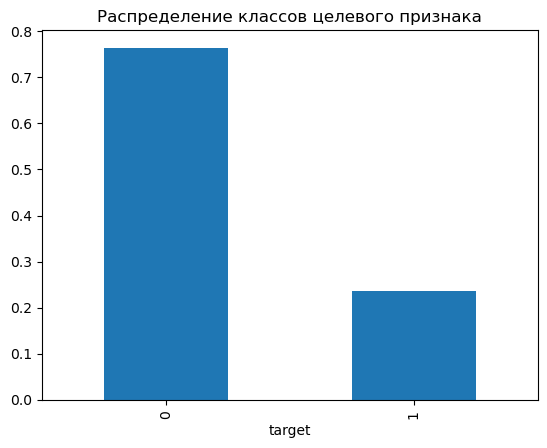

In [17]:
class_frequency = df['target'].value_counts(normalize=True)
display(class_frequency)
class_frequency.plot(kind='bar', title='Распределение классов целевого признака');

Классы не сбалансированы.

In [18]:
print('Количество уникальных категорий:')
df['category'].nunique()

Количество уникальных категорий:


858

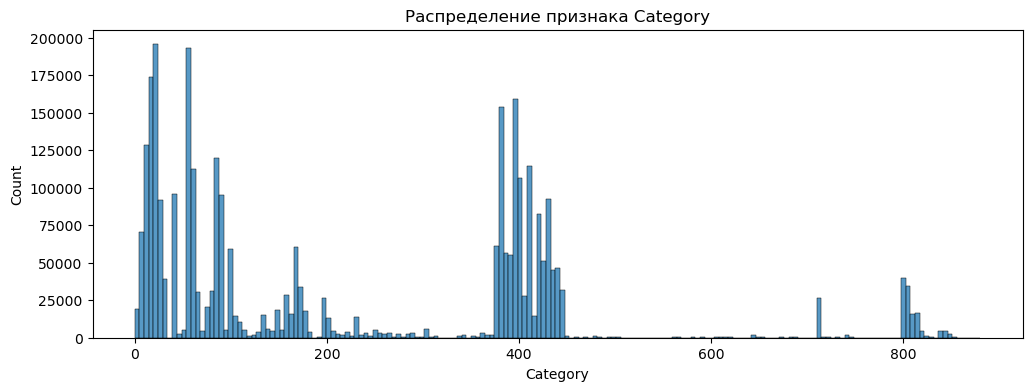

In [19]:
plt.rcParams['figure.figsize'] = (12, 4)
sns.histplot(train_original, x='cart', multiple='stack')
plt.title('Распределение признака Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

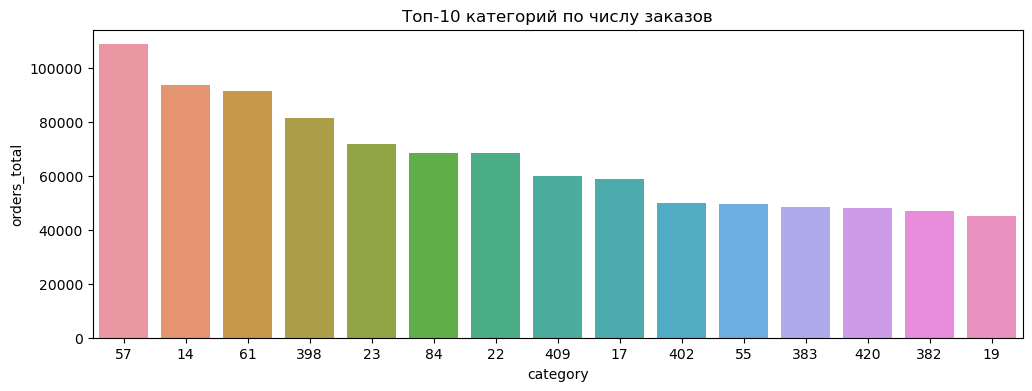

In [20]:
plt.rcParams['figure.figsize'] = (12, 4)
category_orders = train_original.groupby('cart')['user_id'].count().sort_values(ascending=False)
top_categories = pd.DataFrame({'orders_total': category_orders.values, 'category': category_orders.index})
top_15_categories = top_categories.head(15)
top_categories = top_categories.sort_values('orders_total', ascending=False)

top_categories_barplot = sns.barplot(y= 'orders_total', x = 'category', data = top_15_categories, order=top_15_categories['category'])
top_categories_barplot.set_title('Топ-10 категорий по числу заказов');

Исследуем корреляцию признаков

In [21]:
phik_overview = df.phik_matrix().round(2)

interval columns not set, guessing: ['user_id', 'category', 'ordered', 'orders_total', 'rating', 'target', 'total_ordered']


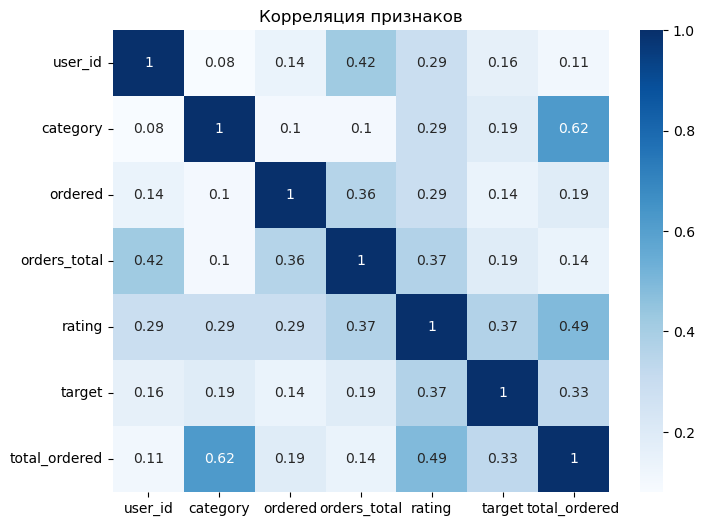

In [22]:
plt.figure(figsize=(8, 6))
sns.heatmap(phik_overview, annot=True,cmap='Blues')
plt.title('Корреляция признаков')
plt.show()

<b>ВЫВОД.</b> Проведен исследовательских анализ данных. Классы целевого признака не сбалансированы. Исследована корреляция между признаками, мультиколлинеарности не обнаружено. Наибольшая зависимость между признаками category и total_ordered. Некоторые категории пользуются значительно большей популярностью. Самая популярная категория - 57.

### Обучение моделей

#### Light GBM

In [23]:
%%time

gbm = lgb.LGBMClassifier(random_state=RANDOM_STATE)

gbm_parametrs = {'learning_rate': [0.01, 0.05, 0.1],
               'max_depth': range(2, 11),
               'num_leaves': [30, 40, 50],
               'n_estimators': [100, 200, 300, 400]
             }

gbm_grid = GridSearchCV(gbm, gbm_parametrs, scoring='f1', cv=5, n_jobs=-1, verbose=10)
begin = time.time()
gbm_grid.fit(X_train, y_train)
end = time.time()
time_gbm = round(end - begin)
print('Время обучения LightGBM:', time_gbm)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[LightGBM] [Info] Number of positive: 155056, number of negative: 477303
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 632359, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.245202 -> initscore=-1.124365
[LightGBM] [Info] Start training from score -1.124365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [24]:
gbm_params = gbm_grid.best_params_
print(gbm_params)

{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300, 'num_leaves': 30}


In [25]:
gbm_scores = gbm_grid.best_score_.round(4)
print('F1 LightGBM:', gbm_scores)

F1 LightGBM: 0.5147


#### Cat Boost

In [26]:
%%time

cb = CatBoostClassifier(random_state=RANDOM_STATE)

cb_parametrs = {'learning_rate': [0.1, 0.2, 0.3],
                'max_depth': range(1, 6),
                'iterations': [500, 600, 700],
                }

cb_grid = GridSearchCV(cb, cb_parametrs, scoring='f1', cv=5, n_jobs=-1, verbose=10)
begin = time.time()
cb_grid.fit(X_train, y_train)
end = time.time()
time_cb = round(end-begin)
print('Время обучения CatBoost:', time_cb)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
0:	learn: 0.6312380	total: 191ms	remaining: 1m 35s
1:	learn: 0.5899750	total: 250ms	remaining: 1m 2s
2:	learn: 0.5618013	total: 300ms	remaining: 49.7s
3:	learn: 0.5393885	total: 347ms	remaining: 43.1s
4:	learn: 0.5204894	total: 397ms	remaining: 39.3s
5:	learn: 0.4996718	total: 467ms	remaining: 38.5s
6:	learn: 0.4846488	total: 516ms	remaining: 36.4s
7:	learn: 0.4734797	total: 564ms	remaining: 34.7s
8:	learn: 0.4635896	total: 608ms	remaining: 33.2s
9:	learn: 0.4549344	total: 660ms	remaining: 32.3s
10:	learn: 0.4484944	total: 708ms	remaining: 31.5s
11:	learn: 0.4433624	total: 755ms	remaining: 30.7s
12:	learn: 0.4383217	total: 798ms	remaining: 29.9s
13:	learn: 0.4340760	total: 849ms	remaining: 29.5s
14:	learn: 0.4311730	total: 896ms	remaining: 29s
15:	learn: 0.4231999	total: 953ms	remaining: 28.8s
16:	learn: 0.4195766	total: 1s	remaining: 28.4s
17:	learn: 0.4163253	total: 1.04s	remaining: 27.9s
18:	learn: 0.4139082	total: 1.09s	

In [27]:
cb_params = cb_grid.best_params_
print(cb_params)

{'iterations': 500, 'learning_rate': 0.1, 'max_depth': 1}


In [28]:
cb_scores = cb_grid.best_score_.round(4)
print('F1 CatBoost:', cb_scores)

F1 CatBoost: 0.4153


#### Random Forest

In [29]:
%%time

rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_parametrs = {'n_estimators': range(5, 100, 30),
                'max_depth': range(2, 10),
                'class_weight' : ['balanced', None]
                }

rf_grid = GridSearchCV(rf, rf_parametrs, scoring='f1', cv=5, n_jobs=-1, verbose=10)
begin = time.time()
rf_grid.fit(X_train, y_train)
end = time.time()
time_rf = end-begin
print(time_rf)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
1334.1248071193695
CPU times: total: 12.6 s
Wall time: 22min 14s


In [30]:
rf_params = rf_grid.best_params_
print(rf_params)

{'class_weight': 'balanced', 'max_depth': 3, 'n_estimators': 35}


In [31]:
rf_scores = rf_grid.best_score_.round(4)
print('F1 RandomForest:', rf_scores)

F1 RandomForest: 0.5616


#### Logistic Regression

In [32]:
%%time

lr = LogisticRegression(random_state=RANDOM_STATE)

pipe = make_pipeline(lr)
parameters = {
    'logisticregression__C': [1, 2, 6],
    'logisticregression__class_weight': ['balanced', None],
}

lr_grid = RandomizedSearchCV(pipe, parameters, cv=5, n_jobs=-1, scoring='f1', verbose=3)
begin = time.time()
lr_grid.fit(X_train_lr, y_train)
end = time.time()
time_lr = end-begin
print(time_lr)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\Iren\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


5.405986070632935
CPU times: total: 2.3 s
Wall time: 5.41 s


In [33]:
lr_params = lr_grid.best_params_
print(lr_params)

{'logisticregression__class_weight': 'balanced', 'logisticregression__C': 2}


In [34]:
lr_scores = lr_grid.best_score_.round(4)
print('F1 LinearRegression:', lr_scores)

F1 LinearRegression: 0.4871


In [35]:
columns = ['Модель', 'Время обучения модели', 'F1']
gbm = ['LightGBM', time_gbm, gbm_scores]
cb = ['CatBoost', time_cb, cb_scores]
rf = ['RandomForest', time_rf, rf_scores]
lr = ['LogisticRegression', time_lr, lr_scores]

table = pd.DataFrame([gbm, cb, rf, lr], columns = columns)
display(table)

,Модель,Время обучения модели,F1
0,LightGBM,6310.000000,0.5147
1,CatBoost,4176.000000,0.4153
2,RandomForest,1334.124807,0.5616
3,LogisticRegression,5.405986,0.4871


<b>ВЫВОД.</b> Исследованы модели LightGBM, CatBoost, RandomForest и LogisticRegression. 
В моделях рассмотрены варианты в том числе с балансировкой классов. Лучшей по метрике F1 является модель RandomForest с параметрами: {'class_weight': 'balanced', 'max_depth': 3, 'n_estimators': 35}. F1 на кросс-валидации составляет 0.5616. Т.к. доступа к истинным меткам тестовой выборки (submit) нет, продолжим работу и с другими моделями.

### Тестирование модели

In [36]:
#LightGBM
test_proba_gbm = gbm_grid.predict_proba(X_test)

y_pred_gbm = gbm_grid.predict(X_test)
print("F1 LightGBM на тестовой выборке:", round(f1_score(y_test, y_pred_gbm), 4))

F1 LightGBM на тестовой выборке: 0.5327


In [37]:
#CatBoost
test_proba_cb = cb_grid.predict_proba(X_test)

y_pred_cb = cb_grid.predict(X_test)
print("F1 CatBoost на тестовой выборке:", round(f1_score(y_test, y_pred_cb), 4))

F1 CatBoost на тестовой выборке: 0.5621


In [38]:
#RandomForest
test_proba_rf = rf_grid.predict_proba(X_test)

y_pred_rf = rf_grid.predict(X_test)
print("F1 RandomForest на тестовой выборке:", round(f1_score(y_test, y_pred_rf), 4))

F1 RandomForest на тестовой выборке: 0.591


In [39]:
#LogisticRegression
test_proba_lr = lr_grid.predict_proba(X_test_lr)

y_pred_lr = lr_grid.predict(X_test_lr)
print("F1 LogisticRegression на тестовой выборке:", round(f1_score(y_test, y_pred_lr), 4))

F1 LogisticRegression на тестовой выборке: 0.4097


Наилучшую метрику F1 на выделенной тестовой выборке показали CatBoost И RandomForest.

### Формирование предсказаний

In [40]:
test = df.copy()

test['orders_total'] += 1 

test['ordered'] = test['ordered'] + test['target']

test_total_ordered = test.groupby('category')['ordered'].sum()
test['total_ordered'] = test['category'].map(test_total_ordered)

test['rating'] = test['ordered'] / test['orders_total']

test = test.drop('target', axis=1)
test.head(3)

,user_id,category,ordered,orders_total,rating,total_ordered
0,7,0,1,11,0.090909,14190
1,8,0,1,8,0.125000,14190
2,9,0,1,46,0.021739,14190


In [41]:
#LightGBM
gbm_final = lgb.LGBMClassifier(**gbm_params)
gbm_final.fit(X, y)

predictions = gbm_final.predict_proba(test)[:, 1]
print('df target mean:', "%.5f" % df.target.mean())
print('Test target mean:', "%.5f" % (predictions > 0.5).astype(int).mean())

th = 0.5
train_mean = df.target.mean()
test_mean = (predictions > th).astype(int).mean()

while test_mean < train_mean:
    th -= 0.005
    test_mean = (predictions > th).astype(int).mean()
    
print('Threshold:', "%.4f" % th)
print('df mean:', "%.5f" % train_mean)
print('New Test mean:', "%.5f" % test_mean)

test['id'] = test['user_id'].astype(str) + ';' + test['category'].astype(str)

test['target'] = (predictions> th).astype(int)
submit = pd.merge(sub['id'], test[['id', 'target']], on='id')
submit.to_csv('submission_gbm_new.csv', index = False)
#Score: 0.48616

[LightGBM] [Info] Number of positive: 186518, number of negative: 603931
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178
[LightGBM] [Info] Number of data points in the train set: 790449, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.235965 -> initscore=-1.174932
[LightGBM] [Info] Start training from score -1.174932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [42]:
#CatBoost
cb_final = CatBoostClassifier(**cb_params)
cb_final.fit(X, y)

test = test.drop('id', axis=1)
predictions = cb_final.predict_proba(test)[:, 1]

print('df target mean:', "%.5f" % df.target.mean())
print('Test target mean:', "%.5f" % (predictions > 0.5).astype(int).mean())

th = 0.5
train_mean = df.target.mean()
test_mean = (predictions > th).astype(int).mean()

while test_mean < train_mean:
    th -= 0.005
    test_mean = (predictions > th).astype(int).mean()
    
print('Threshold:', "%.4f" % th)
print('df mean:', "%.5f" % train_mean)
print('New Test mean:', "%.5f" % test_mean)

test['id'] = test['user_id'].astype(str) + ';' + test['category'].astype(str)

test['target'] = (predictions> th).astype(int)
submit = pd.merge(sub['id'], test[['id', 'target']], on='id')
submit.to_csv('submission_cb_new.csv', index = False)
#Score: 0.48804

0:	learn: 0.6275346	total: 47.4ms	remaining: 23.6s
1:	learn: 0.5827600	total: 105ms	remaining: 26.1s
2:	learn: 0.5531180	total: 154ms	remaining: 25.5s
3:	learn: 0.5295716	total: 204ms	remaining: 25.2s
4:	learn: 0.5099101	total: 261ms	remaining: 25.8s
5:	learn: 0.4888255	total: 323ms	remaining: 26.6s
6:	learn: 0.4733993	total: 375ms	remaining: 26.4s
7:	learn: 0.4619611	total: 429ms	remaining: 26.4s
8:	learn: 0.4519388	total: 483ms	remaining: 26.4s
9:	learn: 0.4432654	total: 534ms	remaining: 26.2s
10:	learn: 0.4368442	total: 585ms	remaining: 26s
11:	learn: 0.4317232	total: 636ms	remaining: 25.9s
12:	learn: 0.4265709	total: 690ms	remaining: 25.9s
13:	learn: 0.4222729	total: 742ms	remaining: 25.7s
14:	learn: 0.4195059	total: 792ms	remaining: 25.6s
15:	learn: 0.4162026	total: 847ms	remaining: 25.6s
16:	learn: 0.4085393	total: 909ms	remaining: 25.8s
17:	learn: 0.4053585	total: 961ms	remaining: 25.7s
18:	learn: 0.4025706	total: 1.01s	remaining: 25.7s
19:	learn: 0.4007305	total: 1.07s	remainin

In [44]:
#RandomForest
rf_final = RandomForestClassifier(**rf_params)
rf_final.fit(X, y)

test = test.drop('id', axis=1)
predictions = rf_final.predict_proba(test)[:, 1]

print('df target mean:', "%.5f" % df.target.mean())
print('Test target mean:', "%.5f" % (predictions > 0.5).astype(int).mean())

th = 0.5
train_mean = df.target.mean()
test_mean = (predictions > th).astype(int).mean()

while test_mean < train_mean:
    th -= 0.005
    test_mean = (predictions > th).astype(int).mean()
    
print('Threshold:', "%.4f" % th)
print('df mean:', "%.5f" % train_mean)
print('New Test mean:', "%.5f" % test_mean)

test['id'] = test['user_id'].astype(str) + ';' + test['category'].astype(str)

test['target'] = (predictions> th).astype(int)
submit = pd.merge(sub['id'], test[['id', 'target']], on='id')
submit.to_csv('submission_rf_new.csv', index = False)
#Score: 0.47579

df target mean: 0.23596
Test target mean: 0.24132
Threshold: 0.5000
df mean: 0.23596
New Test mean: 0.24132


Исследуем важность признаков CatBoost с подобранными параметрами.

In [45]:
model_cb = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    max_depth=1,
    random_state=RANDOM_STATE,
    verbose=False
)
model_cb.fit(X, y)

#получим важность признаков
importances = model_cb.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

print(feature_importances)

         feature  importance
4         rating   53.583524
2        ordered   42.831182
5  total_ordered    3.375344
3   orders_total    0.148373
1       category    0.054932
0        user_id    0.006645


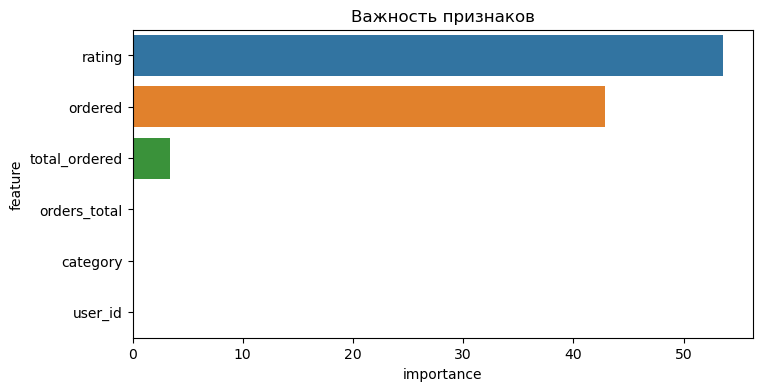

In [46]:
plt.rcParams['figure.figsize']=(8,4)
feature_importances_barplot = sns.barplot(y= 'feature', x = 'importance', data = feature_importances)
feature_importances_barplot.set_title('Важность признаков');

Наилучший скор показала модель CatBoost со значением 0.48804. Если имеет значение скорость обучения, то более оптимальной могла бы быть модель LightGBM. Наиболее важными признаками для модели являются raiting и ordered.

### Вывод

Для решения задачи предсказания категорий в следующем заказе клиента сервиса доставки были исследованы датасеты размерами (3123064, 3), (790449, 2). Они были подготовлены для дальнейшего обучения: рассчитаны целевой и дополнительные признаки, удалены неинформативные столбцы. Размер преобразованного датафрейма для обучения: (790449, 8). Произведено разделение на выборки, произведено масштабирование численных признаков.

Проведен исследовательских анализ данных, который показал, что классы целевого признака не сбалансированы. Исследована корреляция между признаками, мультиколлинеарности не обнаружено. Наибольшая зависимость между признаками category и total_ordered. Некоторые категории пользуются значительно большей популярностью. Самые популярные категории - 57, 14 и 61.

Исследованы модели LightGBM, CatBoost, RandomForest и LogisticRegression. В моделях рассмотрены варианты в том числе с балансировкой классов. 

Наилучший скор показала модель CatBoost со значением 0.48804 и параметрами {'iterations': 500, 'learning_rate': 0.1, 'max_depth': 1}, но её обучение этой модели занимает в 7 раз больше времени, чем, например, LightGBM. Если имеет значение скорость обучения, то более оптимальной могла бы быть модель LightGBM со скором 0.48616. По условию задачи критерий оценки - метрика F1, поэтому итоговый выбор - CatBoost. Наиболее важными признаками для этой модели являются raiting и ordered.